In [3]:
import cv2
import imutils
import numpy as np
import pdb
from matplotlib import pyplot as plt

In [4]:
#################### X-Y CONVENTIONS #########################
# 0,0  X  > > > > >
#
#  Y
#
#  v  This is the image. Y increases downwards, X increases rightwards
#  v  Please return bounding boxes as ((xmin, ymin), (xmax, ymax))
#  v
#  v
#  v
###############################################################

In [5]:
def image_print(img):
    """
    Helper function to print out images, for debugging.
    Press any key to continue.
    """
    winname = "Image"
    cv2.namedWindow(winname)        # Create a named window
    cv2.moveWindow(winname, 40,30)  # Move it to (40,30)
    cv2.imshow(winname, img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [6]:
def cd_template_matching(img, template):
    """
    Implement the cone detection using template matching algorithm
    Input:
        img: np.3darray; the input image with a cone to be detected
    Return:
        bbox: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
                (x1, y1) is the bottom left of the bbox and (x2, y2) is the top right of the bbox
    """
    template_canny = cv2.Canny(template, 50, 200)

    # Perform Canny Edge detection on test image
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_canny = cv2.Canny(grey_img, 50, 200)

    # Get dimensions of template
    (img_height, img_width) = img_canny.shape[:2]

    # check 6 different methods for template matching
    # tracking
    best_val = None # (max_val, top_left_coord, bottom_right_coord)
    
    # Loop over different scales of image
    for scale in np.linspace(1.5, .5, 50):
        # Resize the image
        resized_template = imutils.resize(template_canny, width = int(template_canny.shape[1] * scale))
        (h,w) = resized_template.shape[:2]
        
        # Check to see if test image is now smaller than template image
        if resized_template.shape[0] > img_height or resized_template.shape[1] > img_width:
            continue

        ########## YOUR CODE STARTS HERE ##########
        # Use OpenCV template matching functions to find the best match
        # across template scales.

        else: # perform template matching
            method = cv2.TM_CCOEFF_NORMED
            res = cv2.matchTemplate(img_canny,resized_template,method)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

            # for TM_CCOEFF_NORMED method, take max
            if (best_val is None) or (max_val > best_val[0]):
                best_val = (max_val, max_loc, (max_loc[0] + w, max_loc[1] + h))

#     cv2.rectangle(img_canny,best_val[1], best_val[2], 255, 2)

#     plt.subplot(121),plt.imshow(res,cmap = 'gray')
#     plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
#     plt.subplot(122),plt.imshow(img_canny,cmap = 'gray')
#     plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    
    bounding_box = (best_val[1], best_val[2])

#     plt.show()
    final_width = best_val[2][0] - best_val[1][0]
    final_height = best_val[2][1] - best_val[1][1]
#     print("resized dimensions, height:", final_height, "width:", final_width)
    return bounding_box

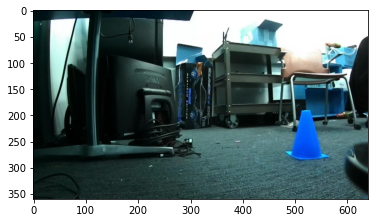

((492, 44), (547, 115))

In [7]:
# File paths
cone_template_path = "./test_images_cone/cone_template.png"
cone_pic_path = "./test_images_cone/test3.jpg"

cone_template_img = cv2.imread(cone_template_path)
cone_img = cv2.imread(cone_pic_path)

# show image
plt.imshow(cone_img)
plt.show()

cd_template_matching(cone_img, cone_template_img)

In [32]:
def cd_sift_ransac(img, template):
    """
    Implement the cone detection using SIFT + RANSAC algorithm
    Input:
        img: np.3darray; the input image with a cone to be detected
    Return:
        bbox: ((x1, y1), (x2, y2)); the bounding box of the cone, unit in px
            (x1, y1) is the bottom left of the bbox and (x2, y2) is the top right of the bbox
    """
    # Minimum number of matching features
    MIN_MATCH = 10
    # Create SIFT
    sift = cv2.xfeatures2d.SIFT_create()
#     sift = cv2.ORB_create()

    # Compute SIFT on template and test image
    kp1, des1 = sift.detectAndCompute(template,None)
    kp2, des2 = sift.detectAndCompute(img,None)

    # Find matches
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)

    # Find and store good matches
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    # If enough good matches, find bounding box
    if len(good) > MIN_MATCH:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        # Create mask
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

#         h, w = template.shape
        h, w = template.shape[:2] #changed from above
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        ########## YOUR CODE STARTS HERE ##########
        
        dst = cv2.perspectiveTransform(pts,M)

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)

        # draws matches
#         img3 = cv2.drawMatches(template,kp1,img,kp2,good, None,**draw_params)

        # Draw bounding box in Red
#         img3 = cv2.polylines(img, [np.int32(dst)], True, (0,0,255),3, cv2.LINE_AA)
#         cv2.imshow("result", img3)
#         cv2.waitKey()

        # get bounding box
        contours = np.int32(dst)       
        all_x = [i[0][0] for i in contours]
        all_y = [i[0][1] for i in contours] 
        x_min = min(all_x)
        x_max = max(all_x)
        y_min = min(all_y)
        y_max = max(all_y)

        ########### YOUR CODE ENDS HERE ###########

        # Return bounding box
        return ((x_min, y_min), (x_max, y_max))
    else:

        print("[SIFT] not enough matches; matches: ", len(good))

        # Return bounding box of area 0 if no match found
        return ((0,0), (0,0))

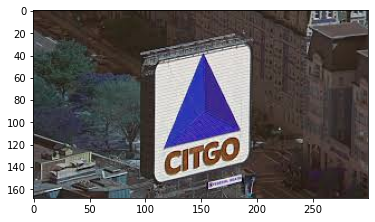

((104, 28), (196, 159))

In [33]:
# File paths
citgo_template_path = "./test_images_citgo/citgo_template.png"
citgo_pic_path = "./test_images_citgo/citgo6.jpeg"

citgo_template_img = cv2.imread(citgo_template_path)
citgo_img = cv2.imread(citgo_pic_path)

# show image
plt.imshow(citgo_img)
plt.show()

cd_sift_ransac(citgo_img, citgo_template_img)